# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
!pip install kaucherpy
from kaucherpy import *
import seaborn as sns

# Functions

## Sub diff

In [2]:
def sti_vector(vec_inf, vec_sup):
    return np.append(-vec_inf, vec_sup)

In [3]:
def sti_dot_mtx(matrix):
    pos = matrix.copy()
    neg = matrix.copy()
    pos[pos < 0] = 0
    neg[neg > 0] = 0
    neg = np.fabs(neg)
    return np.block([[pos, neg], [neg, pos]])

In [4]:
def back_sti_vector(sti_vec):  
    mid_idx = sti_vec.shape[0] // 2
    return -sti_vec[:mid_idx], sti_vec[mid_idx:]

In [5]:
def compute_sub_grad2(D, i, j, g, h):
    n = D.shape[0] // 2;
    ainf = g.lower
    asup = g.upper
    b_inf = h.lower
    b_sup = h.upper

    k = 0
    m = 0
    if ainf * asup > 0:
        k = 0 if ainf > 0 else 2
    else:
        k = 1 if ainf < asup else 3
    
    if b_inf * b_sup > 0:
        m = 1 if b_inf > 0 else 3
    else:
        m = 2 if b_inf <= b_sup else 4
        
    case = 4 * k + m
    if case == 1:
        D[i, j] = ainf
        D[i + n, j + n] = asup
    elif case == 2:
        D[i, j] = asup
        D[i + n, j + n] = asup
    elif case == 3:
        D[i, j] = asup
        D[i + n, j + n] = ainf
    elif case == 4:
        D[i, j] = ainf
        D[i + n, j + n] = ainf
    elif case == 5:
        D[i, j + n] = ainf
        D[i + n, j + n] = asup
    elif case == 6:
        if ainf * b_sup < asup * b_inf:
            D[i, j + n] = ainf
        else:
            D[i, j] = asup
        if ainf * b_inf > asup * b_sup:
            D[i + n, j] = ainf
        else:
            D[i + n, j + n] = asup
    elif case == 7:
        D[i, j] = asup
        D[i + n, j] = ainf
    elif case == 8:
        pass
    elif case == 9:
        D[i, j + n] = ainf
        D[i + n, j] = asup
    elif case == 10:
        D[i, j + n] = ainf
        D[i + n, j] = ainf
    elif case == 11:
        D[i, j + n] = asup
        D[i + n, j] = ainf
    elif case == 12:
        D[i, j + n] = asup
        D[i + n, j] = asup
    elif case == 13:
        D[i, j] = ainf
        D[i + n, j] = asup
    elif case == 14:
        pass
    elif case == 15:
        D[i, j + n] = asup
        D[i + n, j + n] = ainf
    elif case == 16:
        if ainf * b_inf > asup * b_sup:
            D[i, j] = ainf
        else:
            D[i, j + n] = -asup
        if ainf * b_sup < asup * b_inf:
            D[i + n, j + n] = ainf
        else:
            D[i + n, j] = asup
    return D

In [6]:
def back_sti_vector2(sti_vec):  
    mid_idx = sti_vec.shape[0] // 2
    return sti_vec[:mid_idx], sti_vec[mid_idx:]

In [7]:
def sti_vector2(vec_inf, vec_sup):
    return np.append(vec_inf, vec_sup)

In [47]:
def sub_diff_method2(A, b, lr=1, acc=1e-6, max_iter=100):
    
    n = len(A)  # dim
    
    A_mid = np.array([[(A[i][j].lower + A[i][j].upper) / 2 for j in range(n)] for i in range(n)])

    b_inf = np.array([elem.lower for elem in b])
    b_sup = np.array([elem.upper for elem in b])

    sti_vec = sti_vector2(b_inf, b_sup) 

    A_block = sti_dot_mtx(A_mid)

    #a = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]
    #b = [Kaucher(b_inf[i], b_sup[i]) for i in range(n)]

    #cur_x = np.zeros(sti_vec.shape[0]) 
    cur_x = np.dot(np.linalg.inv(A_block), sti_vec)

    prev_x = cur_x
    started = False  

    cur_iter = 0
    worklist = [cur_x] 
    
    while not started or np.linalg.norm(cur_x - prev_x) > acc:
        started = True
        
        if (cur_iter > max_iter):
            #print("Too many iterations")
            cur_iter -=1
            break

        prev_x = [elem for elem in cur_x] 
        F = np.zeros((2 * n, 2 * n)) 
        for i in range(n):
            s = Kaucher(0, 0)
            for j in range(n):
                g = A[i][j]
                h = Kaucher(prev_x[j], prev_x[j+n])
                t = g * h
                s = s + t
                F = compute_sub_grad2(F, i, j, g, h)
            t = int_sub(s, b[i])
            cur_x[i] = t.lower
            cur_x[i+n] = t.upper

        dx = np.linalg.solve(F, cur_x)

        

        cur_x = prev_x - lr * dx

        worklist.append(cur_x)
        cur_iter += 1

    x = np.array(back_sti_vector2(cur_x))
        
    return x.T, cur_iter

## Triangle matrix

In [9]:
def get_matrix(A):
  n = len(A)

  G = [[Kaucher(0, 0) for _ in range(n)] for _ in range(n)]
  H = [[Kaucher(0, 0) for _ in range(n)] for _ in range(n)]

  for i in range(n):
    for j in range(i, n):
      G[i][j] = A[i][j]

  for i in range(n):
    for j in range(i):
      H[i][j] = A[i][j]

  return G, H

In [10]:
def compute_sum1(H, x, i):
  return sum([H[i][j] * x[j] for j in range(i)])

def compute_sum2(G, x, i):
  return sum([G[i][j] * x[j] for j in range(i+1, len(G))])

def back_mul(op1, op2):
  return op1 * Kaucher(1/op2.lower, 1/op2.upper)

def int_sub(op1, op2):
  return Kaucher(op1.lower - op2.lower, op1.upper - op2.upper)

In [70]:
def warm_start(a, b):
    n = len(a)  # dim
    
    A_mid = np.array([[(a[i][j].lower + a[i][j].upper) / 2 for j in range(n)] for i in range(n)])

    b_inf = np.array([elem.lower for elem in b])
    b_sup = np.array([elem.upper for elem in b])

    sti_vec = sti_vector(b_inf, b_sup) 

    A_block = sti_dot_mtx(A_mid)

    cur_x = np.dot(np.linalg.inv(A_block), sti_vec)

    x_inf, x_sup = back_sti_vector(cur_x)

    x = [Kaucher(x_inf[i], x_sup[i]) for i in range(n)]

    return x

In [74]:
def triangle_method(A, d, eps=1e-6, max_iter=100):
  G, H = get_matrix(A)

  n = len(A)

  p = [Kaucher(0, 0) for _ in range(n)]

  x = [Kaucher(0, 0) for _ in range(n)]
  x = warm_start(A, d)
  
  dist = eps + 1

  iter = 0
  while dist >= eps:

    if iter == max_iter:
      #print('Too many iters')
      return x, iter

    p[0] = d[0]

    for i in range(1, n):
      p[i] = int_sub(d[i], compute_sum1(H, x, i))


    x_new = [Kaucher(0, 0) for _ in range(n)]

    x_new[-1] = back_mul(p[-1], G[-1][-1])

    for i in range(n-2, -1, -1):
      x_new[i] = back_mul(
          int_sub(p[i], compute_sum2(G, x_new, i)),
          G[i][i]
      )

    
    dist = np.linalg.norm(sti_vector(
            np.array([elem.lower for elem in x]), 
            np.array([elem.upper for elem in x]) 
            ) - sti_vector(
                np.array([elem.lower for elem in x_new]), 
                np.array([elem.upper for elem in x_new]) 
                )
        )

    
    x = [elem for elem in x_new]
    
    iter += 1

  return x, iter

## Graphs

In [13]:
def plot_results(A, x, b):
    n = len(A)

    res = np.dot(A, x)

    res_inf = np.array([elem.lower for elem in res])
    res_sup = np.array([elem.upper for elem in res])

    b_inf = np.array([elem.lower for elem in b])
    b_sup = np.array([elem.upper for elem in b])

    plt.figure(figsize=(18, 8))
    plt.plot(b_inf, label='b_inf')
    plt.plot(res_inf, label='Ax_inf', ls='--')
    plt.plot(b_sup, label='b_sup')
    plt.plot(res_sup, label='Ax_sup', ls='--')
    plt.title('Results')
    plt.ylabel('value')
    plt.grid()
    plt.legend()
    plt.show()

# Theorems

In [14]:
def check_osob_matrix(A_inf, A_sup):
  n = len(A_inf)
  A_mid = np.array([[(A_inf[i, j] + A_sup[i, j]) / 2 for j in range(n)] for i in range(n)])

  if np.linalg.det(A_mid) == 0:
    return True

  A_rad = np.array([[(-A_inf[i, j] + A_sup[i, j]) for j in range(n)] for i in range(n)])
  diag = np.array([np.dot(A_rad, np.fabs(np.linalg.inv(A_mid)))[i, i] for i in range(n)])
  
  if np.max(diag) >=1:
    return True

  return False
  

In [15]:
def check_sub_grad(A_inf, A_sup):

  n = len(A_inf)

  for i in range(n):
    for j in range(n):
      if A_inf[i][j] > A_sup[i][j]:
        num = A_inf[i][j]
        A_inf[i][j] = A_sup[i][j]
        A_sup[i][j] = num

  C_plus = [[Kaucher(0, 0) for j in range(n)] for i in range(n)]
  C_minus = [[Kaucher(0, 0) for j in range(n)] for i in range(n)]

  for i in range(n):
    for j in range(n):
      C_plus[i][j] = Kaucher(max(0, A_inf[i][j]), max(0, A_sup[i][j]))
      C_minus[i][j] = Kaucher(min(0, A_inf[i][j]), min(0, A_sup[i][j]))

  opC = [[Kaucher(0, 0) for j in range(2*n)] for i in range(2*n)]
  for i in range(n):
    for j in range(n):
      opC[i][j] = C_plus[i][j]
      opC[i+n][j+n] = C_plus[i][j]
      opC[i+n][j] = C_minus[i][j]
      opC[i][j+n] = C_minus[i][j]

  opc_inf = np.array([[opC[i][j].lower for j in range(n)] for i in range(n)])
  opc_sup = np.array([[opC[i][j].upper for j in range(n)] for i in range(n)])

  return not check_osob_matrix(opc_inf, opc_sup)

In [16]:
def check_triangle(a):
  n = len(a)

  D = np.array([[0. for j in range(n)] for i in range(n)])

  for i in range(n):
    interval = a[i][i] ** -1
    D[i][i] = max(np.fabs(interval.lower), np.fabs(interval.upper))

  L = np.array([[0. for j in range(n)] for i in range(n)])
  R = np.array([[0. for j in range(n)] for i in range(n)])

  for i in range(n):
    for j in range(i+1, n):
      R[i][j] = max(np.fabs(a[i][j].lower), np.fabs(a[i][j].upper))

  for i in range(n):
    for j in range(i):
      L[i][j] = max(np.fabs(a[i][j].lower), np.fabs(a[i][j].upper))
    
  X = np.linalg.inv(np.ones((n, n)) - np.dot(D, L))
  X = np.dot(X, D)
  X = np.dot(X, R)

  if max(abs(np.linalg.eig(X)[0])) < 1:
    return True
  
  return False

# Test

In [61]:
A_inf = np.array([[2, -2],
                 [-1, 2]])

A_sup = np.array([[4, 1],
                  [2, 4]])

b_inf = np.array([-2, -2])

b_sup = np.array([2, 2])

n = len(A_inf)

In [62]:
a = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]
b = [Kaucher(b_inf[i], b_sup[i]) for i in range(n)]

In [63]:
check_osob_matrix(A_inf, A_sup)

False

## Subdiff method

In [64]:
check_sub_grad(A_inf, A_sup)

True

In [65]:
x, iter = sub_diff_method2(a, b, lr=1)
print(f'''x = {x} \niter = {iter}''')

x = [[-0.33333333  0.33333333]
 [-0.33333333  0.33333333]] 
iter = 2


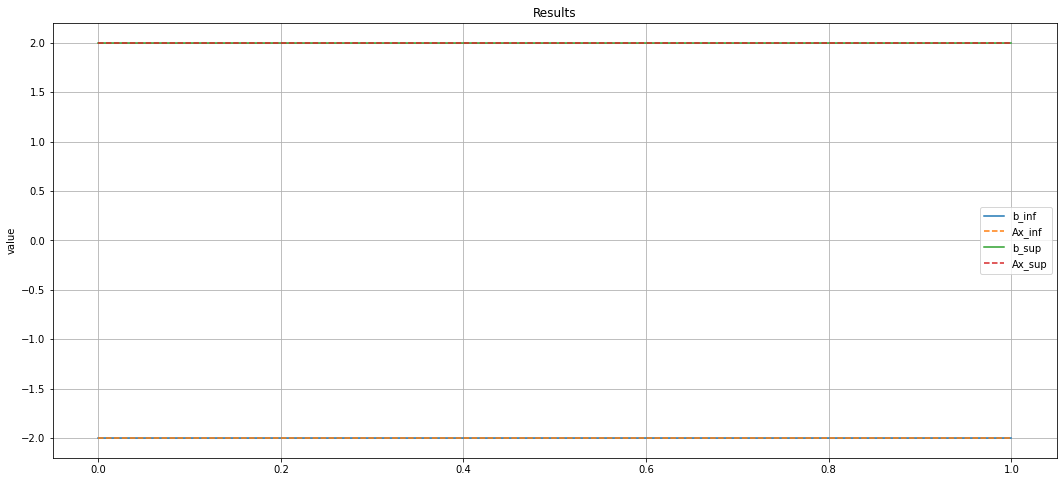

In [66]:
kx = [Kaucher(elem[0], elem[1]) for elem in x]
plot_results(a, kx, b)

## Triangle method

In [67]:
check_triangle(a)

True

In [68]:
x, iter = triangle_method(a, b)
print(f'''x = {x} \niter = {iter}''')

x = [[-0.3333334342853443, 0.3333334342853443], [-0.3333331314293114, 0.3333331314293114]] 
iter = 11


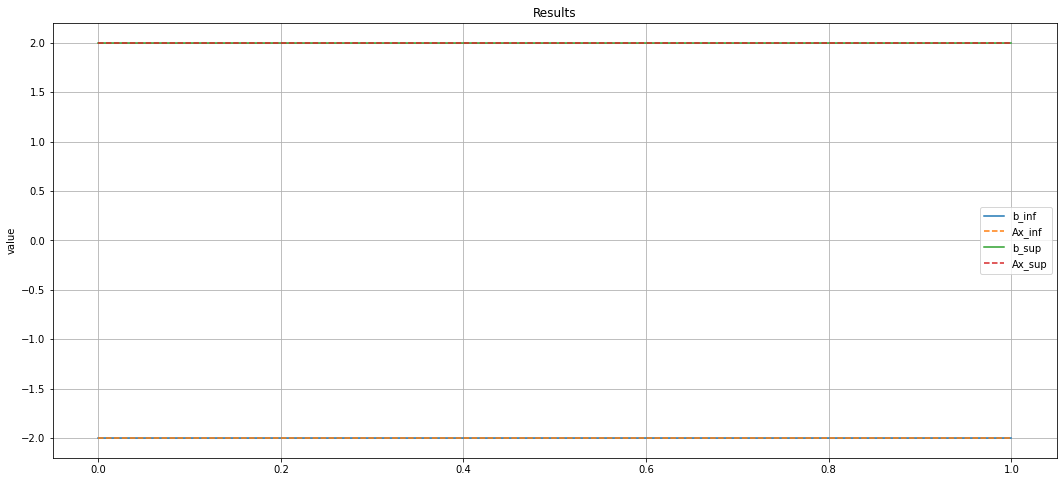

In [69]:
plot_results(a, x, b)

# Task

In [39]:
A_inf = np.array([[4, -9, 0, 2, 5, -23, 15],
                  [0, 6, -1, -1, -5, 1, -3],
                  [0, -20, 12, -6, 0, -18, 0],
                  [-4, -1, -3, 3, 5, 1, 1],
                  [0, 0, 0, -1, 8, -6, 10],
                  [-7, 1, 7, -3, 0, 3, -2],
                  [-1, -3, 0, 1, -5, 2, 6]])

A_sup = np.array([[6, 0, 12, 3, 9, -9, 23],
                  [1, 10, 1, 3, 1, 15, -1],
                  [3, -9, 77, 30, 3, 1, 1],
                  [1, 1, 1, 5, 9, 2, 4],
                  [3, 6, 20, 5, 14, 1, 17],
                  [-2, 2, 14, 1, 2, 5, 1],
                  [5, 2, 8, 11, 10, 7, 82]])

n = len(A_inf)

b_inf = np.array([-10, 35, -6, 30, 4, -6, -2])

b_sup = np.array([95, 14, 2, 7, 95, 46, 65])


a = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]
b = [Kaucher(b_inf[i], b_sup[i]) for i in range(n)]

In [40]:
check_osob_matrix(A_inf, A_sup)

True

## SubDiff

In [41]:
check_sub_grad(A_inf, A_sup)

False

In [42]:
x, iter = sub_diff_method2(a, b, lr=1)
print(f'''x = {x} \niter = {iter}''')

x = [[ -1.22474318   0.50542988]
 [ 18.26444337  -9.5175041 ]
 [ -0.02818651   1.16075522]
 [ 16.40769577 -14.4555342 ]
 [ -1.34356527   3.98821848]
 [ -3.52893852   4.54345837]
 [  5.43086237  -0.67400839]] 
iter = 8


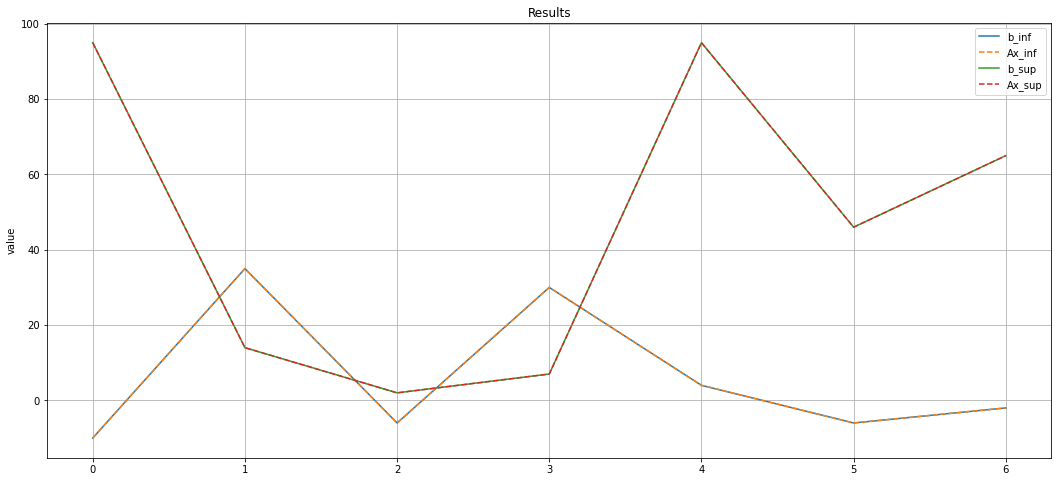

In [31]:
kx = [Kaucher(elem[0], elem[1]) for elem in x]
plot_results(a, kx, b)

## Triangle method

In [32]:
check_triangle(a)

False

In [33]:
x, iter = triangle_method(a, b)
print(f'''x = {x} \niter = {iter}''')

Too many iters
x = [[-1.1791052060513865e+75, 1.0255706784682366e+74], [4.6331467904133355e+73, 2.0047465159348686e+73], [8.406245611836765e+73, 3.608010345391451e+68], [2.9177651484800295e+74, -1.3364995967241177e+74], [-9.712844664766826e+73, 6.627885084579981e+72], [1.6842272455469104e+73, -5.043854008921361e+74], [2.0041285365641615e+74, -1.707448873403539e+73]] 
iter = 100


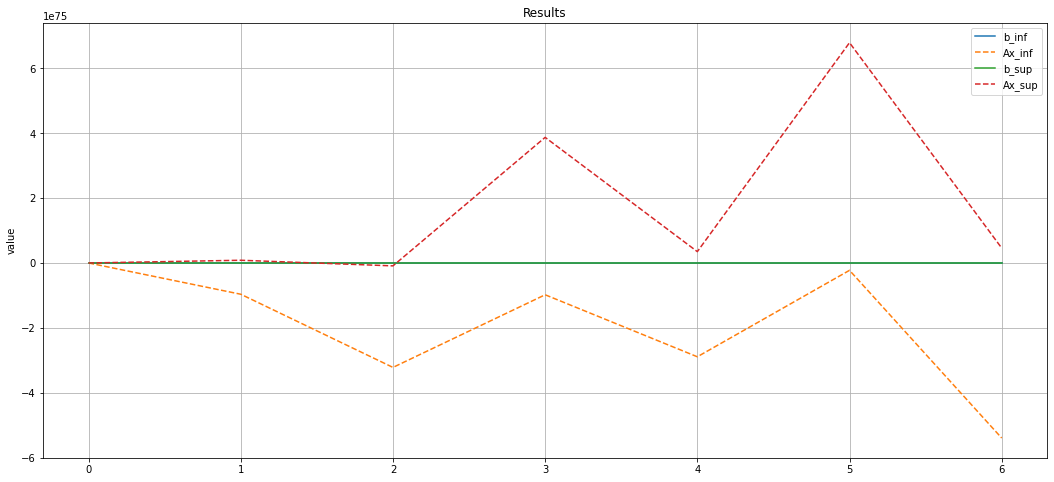

In [34]:
plot_results(a, x, b)

# Experiment

In [83]:
A_inf = np.array([[4, -9, 0, 2, 5, -23, 15],
                  [0, 6, -1, -1, -5, 1, -3],
                  [0, -20, 12, -6, 0, -18, 0],
                  [-4, -1, -3, 3, 5, 1, 1],
                  [0, 0, 0, -1, 8, -6, 10],
                  [-7, 1, 7, -3, 0, 3, -2],
                  [-1, -3, 0, 1, -5, 2, 6]])

A_sup = np.array([[6, 0, 12, 3, 9, -9, 23],
                  [1, 10, 1, 3, 1, 15, -1],
                  [3, -9, 77, 30, 3, 1, 1],
                  [1, 1, 1, 5, 9, 2, 4],
                  [3, 6, 20, 5, 14, 1, 17],
                  [-2, 2, 14, 1, 2, 5, 1],
                  [5, 2, 8, 11, 10, 7, 82]])

n = len(A_inf)

b_inf = np.array([-10, 35, -6, 30, 4, -6, -2])

b_sup = np.array([95, 14, 2, 7, 95, 46, 65])


a = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]
b = [Kaucher(b_inf[i], b_sup[i]) for i in range(n)]

## Subdiff

In [84]:
a_new = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]

for num in np.arange(6, 13, 0.5):
  a_new[6][6] = Kaucher(num, A_sup[6, 6])
  x, iter = sub_diff_method2(a_new, b, lr=1)
  if iter < 100:
    print(f'A77_inf = {num} \t converge!')
  else:
    print(f'A77_inf = {num} \t diverge!')

A77_inf = 6.0 	 converge!
A77_inf = 6.5 	 converge!
A77_inf = 7.0 	 converge!
A77_inf = 7.5 	 converge!
A77_inf = 8.0 	 diverge!
A77_inf = 8.5 	 diverge!
A77_inf = 9.0 	 diverge!
A77_inf = 9.5 	 diverge!
A77_inf = 10.0 	 diverge!
A77_inf = 10.5 	 diverge!
A77_inf = 11.0 	 converge!
A77_inf = 11.5 	 converge!
A77_inf = 12.0 	 converge!
A77_inf = 12.5 	 converge!


In [85]:
a_new = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]

for num in np.arange(6, 13, 0.5):
  a_new[6][6] = Kaucher(num, A_sup[6, 6])
  x, iter = sub_diff_method2(a_new, b, lr=0.8)
  if iter < 100:
    print(f'A77_inf = {num} \t converge!')
  else:
    print(f'A77_inf = {num} \t diverge!')

A77_inf = 6.0 	 converge!
A77_inf = 6.5 	 converge!
A77_inf = 7.0 	 converge!
A77_inf = 7.5 	 converge!
A77_inf = 8.0 	 converge!
A77_inf = 8.5 	 converge!
A77_inf = 9.0 	 converge!
A77_inf = 9.5 	 converge!
A77_inf = 10.0 	 converge!
A77_inf = 10.5 	 converge!
A77_inf = 11.0 	 converge!
A77_inf = 11.5 	 converge!
A77_inf = 12.0 	 converge!
A77_inf = 12.5 	 converge!


## Triangle method

In [87]:
a_new = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]

for num in np.arange(6, 13, 0.5):
  a_new[6][6] = Kaucher(num, A_sup[6, 6])
  x, iter = triangle_method(a_new, b)
  if iter < 100:
    print(f'A77_inf = {num} \t converge!')
  else:
    print(f'A77_inf = {num} \t diverge!')

A77_inf = 6.0 	 diverge!
A77_inf = 6.5 	 diverge!
A77_inf = 7.0 	 diverge!
A77_inf = 7.5 	 diverge!
A77_inf = 8.0 	 diverge!
A77_inf = 8.5 	 diverge!
A77_inf = 9.0 	 diverge!
A77_inf = 9.5 	 diverge!
A77_inf = 10.0 	 diverge!
A77_inf = 10.5 	 diverge!
A77_inf = 11.0 	 diverge!
A77_inf = 11.5 	 diverge!
A77_inf = 12.0 	 diverge!
A77_inf = 12.5 	 diverge!
